# Porto Seguro Safe Driver - Supervised Learning

## Data Import and EDA

### Import the Data

Import all libraries needed for the project, and import the data into a dataframe. 

In [122]:
# Importing needed libraries 
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

# For scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Import the dataset
dataset = pd.read_csv('data/train.csv', index_col='id')
# Create dataframe
df = pd.DataFrame(dataset)
# Check dataset
df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Get an overview of the number and types of values in the dataset and create a features summary.

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

In [124]:
df['ps_ind_03'].dtype == np.int64

True

In [125]:
summary = pd.DataFrame(df.dtypes, columns=['data types'])
# Calculate the number of missing values
summary['# missing values'] = (df == -1).sum().values 
# Number of unique values by features
summary['# unique values'] = df.nunique().values # -> eg. target as 2 unique values as it is 

# Get the type of data in each column
variable_types = []
for col in df.columns: 
    if 'bin' in col or col == 'target':
        variable_types.append('binary')
    elif 'cat' in col: 
        variable_types.append('nominal') # means categorical without any ranking
    elif df[col].dtype == float: 
        variable_types.append('continuous')
    elif df[col].dtype == np.int64:
        variable_types.append('categorical')
summary['variable type'] = variable_types

# View the top of this dataframe
summary.head()

,data types,# missing values,# unique values,variable type
target,int64,0,2,binary
ps_ind_01,int64,0,8,categorical
ps_ind_02_cat,int64,216,5,nominal
ps_ind_03,int64,0,12,categorical
ps_ind_04_cat,int64,83,3,nominal


In [126]:
# Get the names of the columns of a certain variable type 
summary[summary['variable type'] == 'nominal'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

### Value Distributions Visualisation

#### Target Value

Check how balanced (or not) the target value is among the training data.

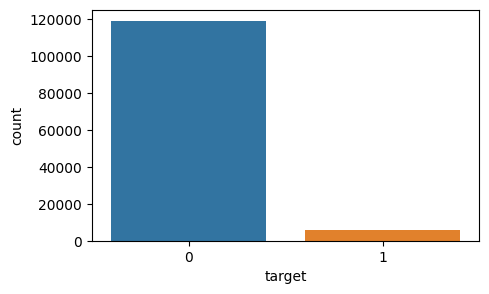

In [141]:
plt.figure(figsize=(5, 3)) # Create a figure

ax = sns.countplot(df, x='target') # countplot: Show the counts of observations in each categorical bin using bars.

#### Feature Distribution

How is each feature distributed looking at the target values? 

In [128]:
def plot_target_ratio_by_feat(datatype='binary', legend='on'): 
    cols = summary[summary['variable type'] == datatype].index
    ncols = 4
    nrows = len(cols) // ncols if len(cols) % ncols == 0 else len(cols) // ncols + 1
    # Create grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
    axes = axes.flatten() # Flatten the axes array for easy iteration
    
    for i, feature in enumerate(df[cols]):
        sns.countplot(df, x='target', hue=feature, ax=axes[i])
        # turn off legend if set
        if legend == 'off':
            axes[i].legend().set_visible(False)
        # set the title for each subplot
        axes[i].set_title(f'Countplot for {col}')
    
    plt.tight_layout()

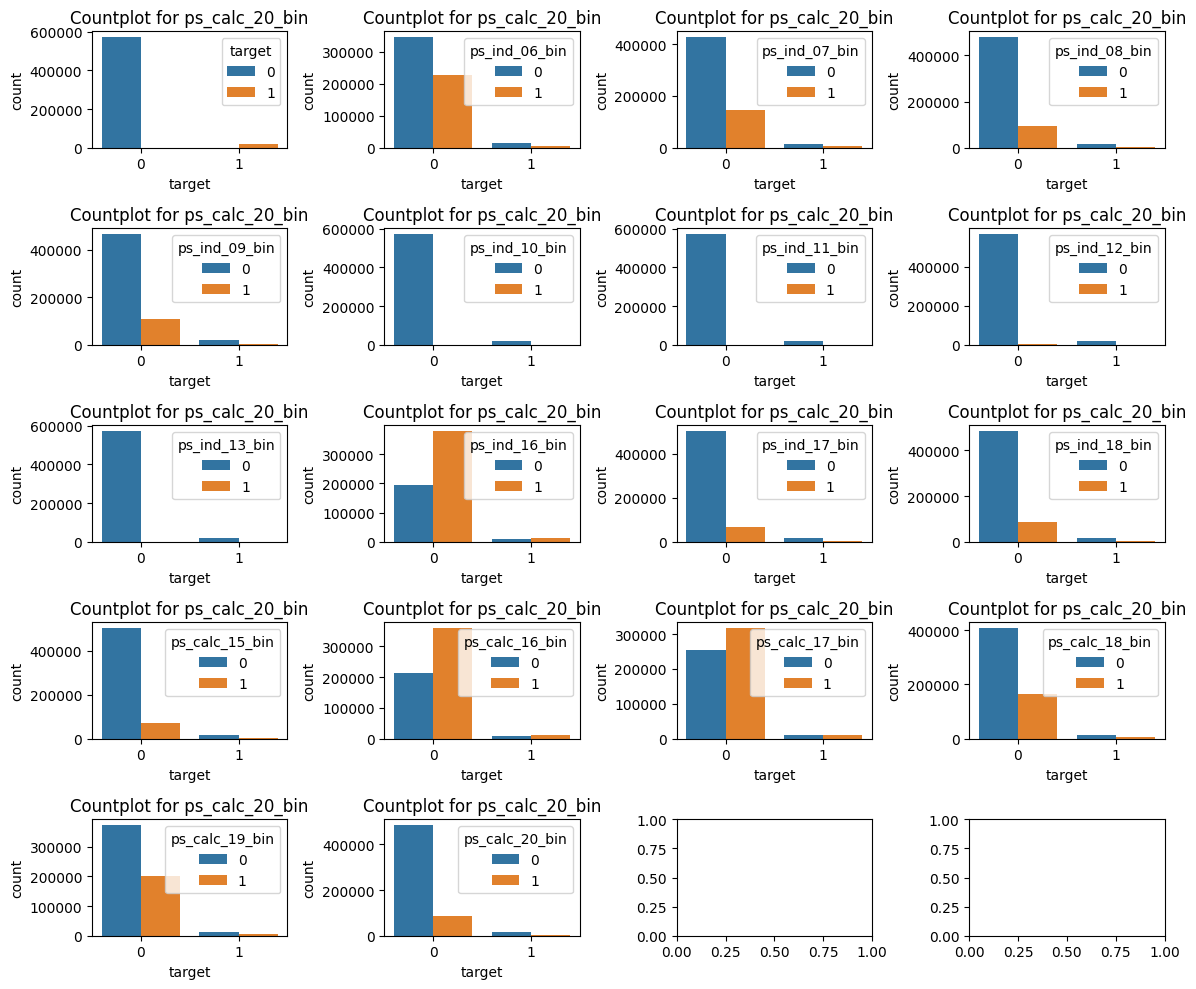

In [129]:
plot_target_ratio_by_feat(datatype='binary')

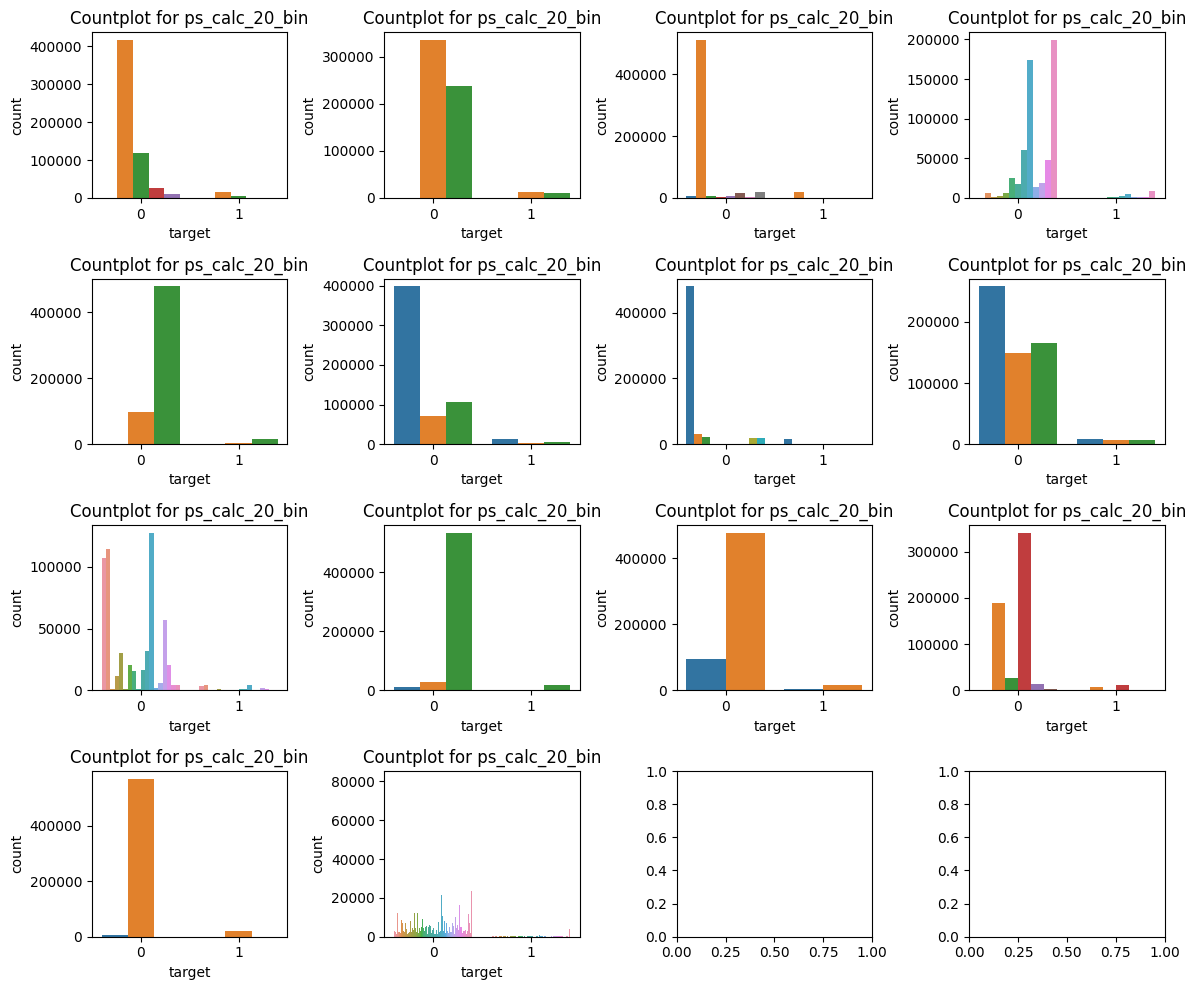

In [130]:
plot_target_ratio_by_feat(datatype='nominal', legend='off')

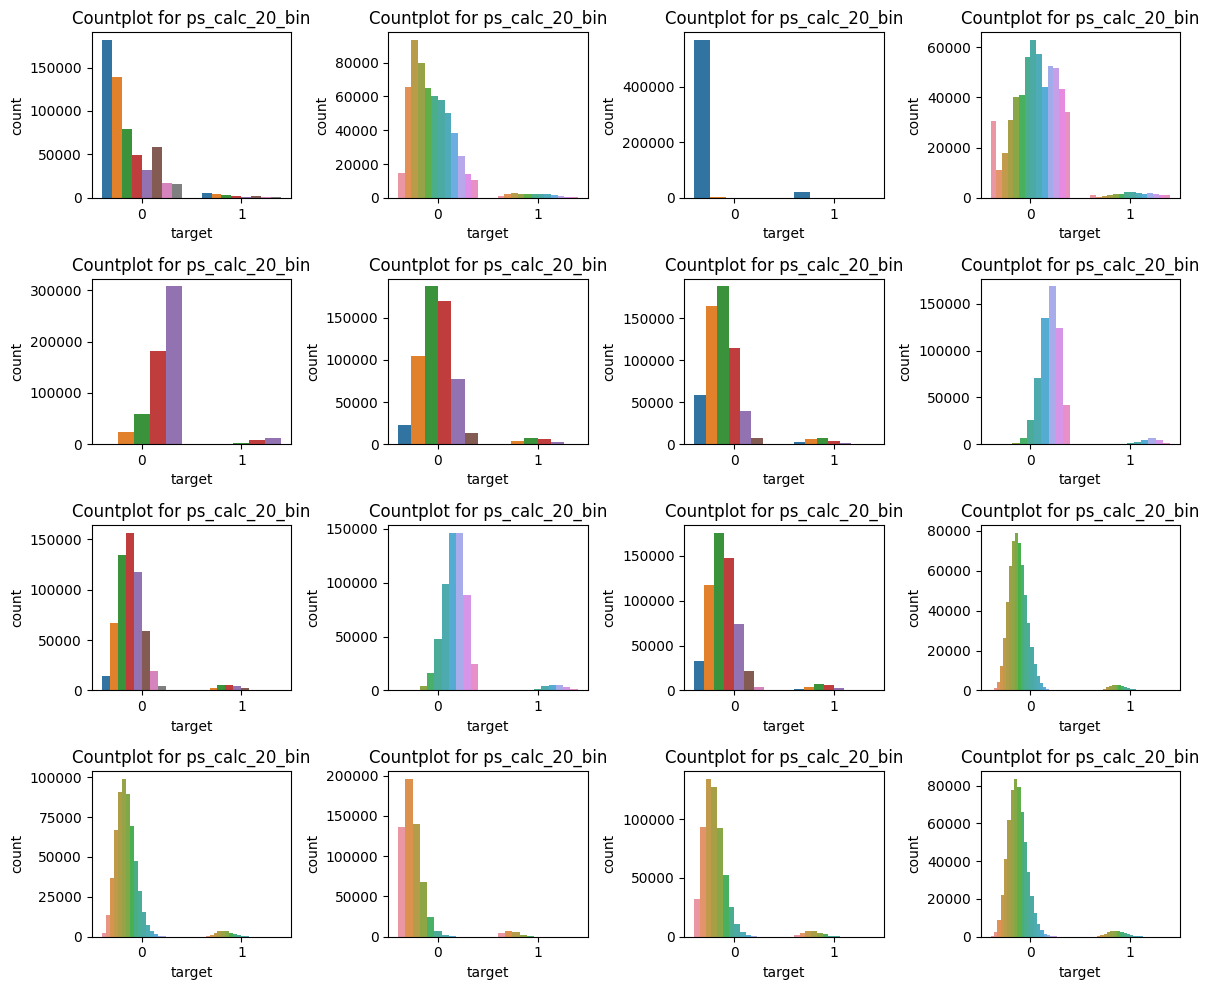

In [131]:
plot_target_ratio_by_feat(datatype='categorical', legend='off')

### Remove Missing Values 

Remove the missing values 

In [132]:
# 1. Remove missing values: All our missing data is marked with -1, so remove every row that has a -1 in it: 
df.replace(-1, np.NaN, inplace=True) # replace the -1 values with NaN, since they indicate missing data
df.dropna(inplace=True)

### Correlation Matrix

Check the correlation among continuous features. 

<AxesSubplot:>

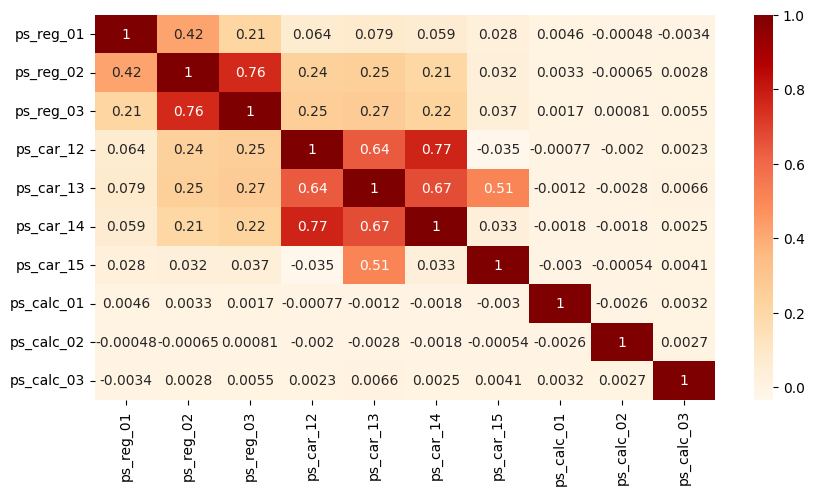

In [133]:
# Find correlating features: 
plt.figure(figsize=(10, 5))
c = df[summary[summary['variable type'] == 'continuous'].index].corr() # Compute pairwise correlation of columns
sns.heatmap(c, annot=True, cmap='OrRd')

### Undersampling

To combat the uneven distribution of target values and prevent our model from classifying everything into 0. 

Undersampling is a technique to balance the target value distribution for a classification dataset that has a skewed target (= class) distribution. 
Undersampling removes examples from the training dataset that belong to the majority class (in our case: no insurance claim (0)) in order to better balance the class distribution (e.g., reducing the skew from 1:100 to 1:10, 1:2, or even 1:1). 

#### Random Undersampling 

Simply removes randomly selected examples from the training data. However, it might remove useful information: The major drawback of random undersampling is that this method can discard potentially useful data that could be important for the induction process. 

#### Remove Redundant Examples only

This typically involves heuristics or learning models that attempt to identify redundant examples for deletion or useful examples for non-deletion. 

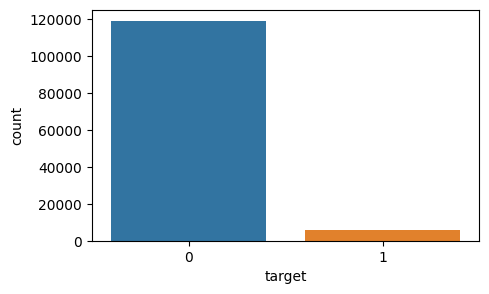

In [148]:
# Remember the distribution of target values: 
plt.figure(figsize=(5, 3)) # Create a figure

ax = sns.countplot(df, x='target') # countplot: Show the counts of observations in each categorical bin using bars.

In [176]:
# Random Undersampling 
print('Shape of data:', df.shape)
print('Number of entries with classification 0:', df[df['target'] == 0].shape[0])
print('Number of entries with classification 1:', df[df['target'] == 1].shape[0])

# Select 5670 entries from the 0 target value entries 
X = df[df['target'] == 0].iloc[:5670, 1:].append(df[df['target'] == 1].iloc[:, 1:]) # Take the first 5670 entries of 0 + all of 1
y = df[df['target'] == 0].iloc[:5670, :1].append(df[df['target'] == 1].iloc[:, :1]) 

Shape of data: (124931, 58)
Number of entries with classification 0: 119261
Number of entries with classification 1: 5670


C:\Users\Laura\AppData\Local\Temp\ipykernel_29616\860865207.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = df[df['target'] == 0].iloc[:5670, 1:].append(df[df['target'] == 1].iloc[:, 1:]) # Take the first 5670 entries of 0 + all of 1
C:\Users\Laura\AppData\Local\Temp\ipykernel_29616\860865207.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = df[df['target'] == 0].iloc[:5670, :1].append(df[df['target'] == 1].iloc[:, :1])


### Split into Train and Testing Sets

In [177]:
# # 2. Split into train and testing data 
# X = df.iloc[:, 1:] # dropping the target columns
# y = df['target'] # just the target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Removing Outliers

Removes all outliers from `X_train` and `y_train`. 

In [178]:
# 3. Remove outliers: It depends on what you exactly need for your use-case, but if you remove outliers after standardizing, the resulting data won't be standardized anymore (if many outliers are removed, standard deviation could become considerably smaller than 1)
# identify outliers in the training dataset
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X_train) # Label is 1 for an inlier and -1 for an outlier
# select all rows that are not outliers
inlier_indexes = y_pred == 1

# Remove from X_train and y_train
X_train, y_train = X_train[inlier_indexes], y_train[inlier_indexes]

### Scaling the Data

In [179]:
def scale_data(X_train, X_test, type='sta'):
    """
    This function gets the train and test data, and scales it. 

    Parameters:
    - X_train: The training data 
    - y_train: The labels of the training data 
    - X_test: The testing data 
    - y_test: The labels of the testing data 
    - type: The type of scaler to use, either `mm` for MinMax Scaling or `sta` for Standard Scaling.

    Returns:
    X_train, y_train, X_test, y_test scaled

    Example:
    >>> X_train, y_train, X_test, y_test = scale_data(scaling='mm')
    """
    
    if (type == 'mm'):
        mm = MinMaxScaler()
        X_train_scaled = mm.fit_transform(X_train)
        X_test_scaled = mm.fit_transform(X_test)
    elif (type == 'sta'):
        sta = StandardScaler()
        X_train_scaled = sta.fit_transform(X_train)
        X_test_scaled = sta.fit_transform(X_test)
    else: 
        return "No correct scaling method."
    
    print("Scaled data, size of X_train:", X_train_scaled.shape, "size of X_test:", X_test_scaled.shape)
    
    return X_train_scaled, X_test_scaled
        

In [180]:
X_train, X_test = scale_data(X_train, X_test)

Scaled data, size of X_train: (8164, 57) size of X_test: (2268, 57)


In [181]:
print("Size of y_train:", y_train.shape, "size of y_test:", y_test.shape)

Size of y_train: (8164, 1) size of y_test: (2268, 1)


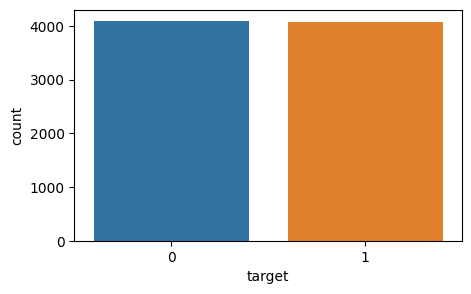

In [182]:
# Remember the distribution of target values: 
plt.figure(figsize=(5, 3))

ax = sns.countplot(pd.DataFrame(y_train), x='target') # countplot: Show the counts of observations in each categorical bin using bars.

# Model Selection

## Classification 

Classification with scikit's `MLPClassifier`, which implements a multi-layer perceptron algorithm that trains using Backpropagation [[Source]](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

I'm going to try with both the normalised and the standardised data.

In [183]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train) # Train the classifier 

y_pred = clf.predict(X_test)

c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Laura\anaconda3\envs\F21DL\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation

[[703 463]
 [513 589]]


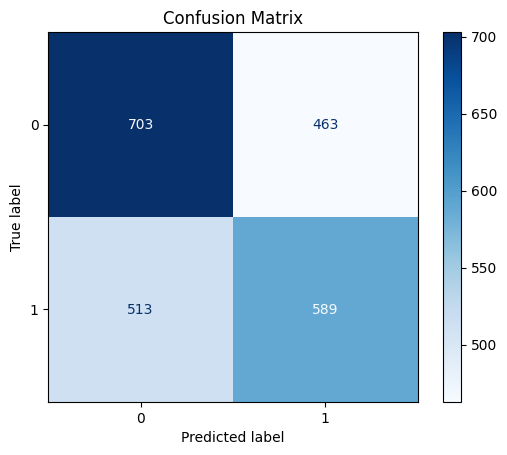

In [184]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)

# confusion_matrix(y_test, y_pred)

[imported from old file, use as needed]

# Model Evaluation 

### Evaluation

We can look at the following classification metrics: 

1. Accuracy
2. Precision and Recall
3. F1-Score
4. ROC-AUC (The area under the receiver operating characteristic curve. It shows the capability of a model to distinguish between classes.)

### Validation 

There are different methods to validate the model: 

1. Holdout Method
2. K-Fold Cross-Validation
3. Startified and Time-Series Splits